# Výběr příznaků

Narozdíl od metod pro redukci dat, které vlastně z existujících příznaků počítají menší množství nových příznaků, metody pro výběr příznaků "pouze" vynechávají příznaky, které se pro danou úlohu zdají málo důležité. 

## Náhodný výběr a náhodné lesy

Nejjednodušším výběrem je výběr náhodný. Ten může sám o sobě vypadat málo užitečně, ale některé pokročilé metody strojového učení jej používají jako svou součást - například náhodné lesy. V náhodných lesech se vždy vybere náhodna podmožina všech příznaků a na ní se postaví klasifikační (nebo regresní) strom. Tímto způsobem se vytvoří velké množství stromů a ty se nechají hlasovat. Zajímavé je, že stromové algoritmy často takéumíspočítat důležitosti jednotlivých atributů. V případě knihovny scikit-learn a náhodných lesů se počítá tzv. Gini importance. Zkusme si ji zase namalovat na našich menších datech (stejných jako v předchozím textu).

Accuracy:  0.646666666667
             precision    recall  f1-score   support

          0       1.00      0.20      0.33        10
          1       0.55      0.58      0.56        19
          2       0.80      0.40      0.53        10
          3       0.63      0.96      0.76        73
          4       1.00      0.31      0.47        13
          5       0.67      0.22      0.33         9
          6       0.80      0.25      0.38        16

avg / total       0.71      0.65      0.60       150



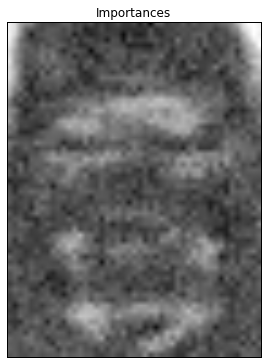

In [47]:
from sklearn import datasets
from sklearn import ensemble
from sklearn import cross_validation
from sklearn import metrics

def plot_img(ax, img, title=''):    # jednoducha utilitka na nakresleni obrazku do os grafu
    ax.imshow(img, cmap=plt.cm.gray)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(title)

data = datasets.fetch_lfw_people(min_faces_per_person=70)

train_x, test_x, train_y, test_y = cross_validation.train_test_split(data.data, data.target, test_size=150)

clf = ensemble.RandomForestClassifier(n_estimators=500)
clf.fit(train_x, train_y)
clf_y = clf.predict(test_x)

print('Accuracy: ', metrics.accuracy_score(test_y, clf_y))
print(metrics.classification_report(test_y, clf_y))

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(5,6))
ax = plt.subplot(111)
plot_img(ax, np.log(clf.feature_importances_.reshape((62,47))), title='Importances')

## Výběr na základě rozptylu

Dalším velmi jendoduchým kritériem pro výběr příznků  může být jejich rozptyl. Příznaky s velmi malým nebo dokonce nulovým rozptylem budou mít pravděpodobně malý vliv na cílovou třídu/hodnotu. Spočítání rozptylů je snadné.

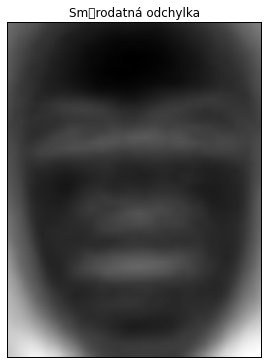

In [55]:
import numpy as np

img = np.std(data.data, axis=0)

fig = plt.figure(figsize=(5,6))
ax = fig.add_subplot(111)
plot_img(ax, img.reshape((62, 47)), 'Směrodatná odchylka')

## Výběr podle statistiky

Příznaky také můžeme vybírat na základě statistických testů závislosti cílové třídy na konkrétním příznaku. Zde pro klasifikaci použijeme buď ANOVA test, nebo ch2 test.

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: divide by zero encountered in log
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: RuntimeWarning: divide by zero encountered in log


[ 103.27893066  103.27893066  103.27893066   91.15202332   54.02540207
   31.28129196   20.4255352    16.74133873   16.31502533   16.24283791]


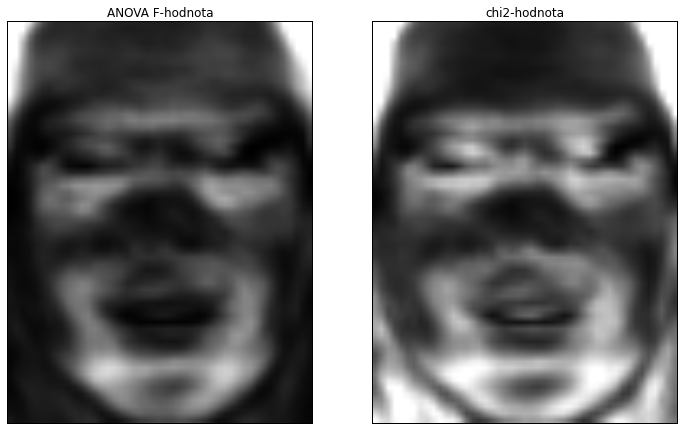

In [73]:
from sklearn import feature_selection

kbest = feature_selection.SelectKBest()
kbest.fit(data.data, data.target)

img = -np.log(kbest.pvalues_)
img[img==np.inf] = max(img[img!=np.inf])  # opravime nekonecna z logaritmu 0

print(img[:10])

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(121)
plot_img(ax, img.reshape((62, 47)), 'ANOVA F-hodnota')

kbest = feature_selection.SelectKBest(feature_selection.chi2)
kbest.fit(data.data, data.target)

img = -np.log(kbest.pvalues_)
img[img==np.inf] = max(img[img!=np.inf])  # opravime nekonecna z logaritmu 0

ax = fig.add_subplot(122)
plot_img(ax, img.reshape((62, 47)), 'chi2-hodnota')

## Další metody výběru příznaků

Uvedený seznam samozřejmě není úplný, existují i metody selekce příznaků založené na postupném odstraňování nejméně důležitých příznaků podle toho, jak je ohodnotí nějaký model. Selekce příznaků se dá formulovat i jako optimalizační problém, kde se prohledává prostor všech podmnožin množiny příznaků a optimalizuje se výkon naučeného modelu. V takovém případě se dá použít libovolná optimalizační technika od jednoduchého náhodného prohledávání, přes simulované žíhání až po evoluční algoritmy. Nicméně je třeba dát pozor na to, že mnoho metod strojového učení je stochastických, takže i se stejnou množinou příznaků na začátku mohou podávat různě kvalitní výsledky. Je nutné používat krosvalidaci a věnovat pozornost výběru konečné množiny příznaků i s přihlédnutím k rozptylu krosvalidace a možností i přeučení (dokonce se lze přeučit i na konkrétní rozdělení testovacích a trénovacích množin v krosvalidaci).